In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import everest

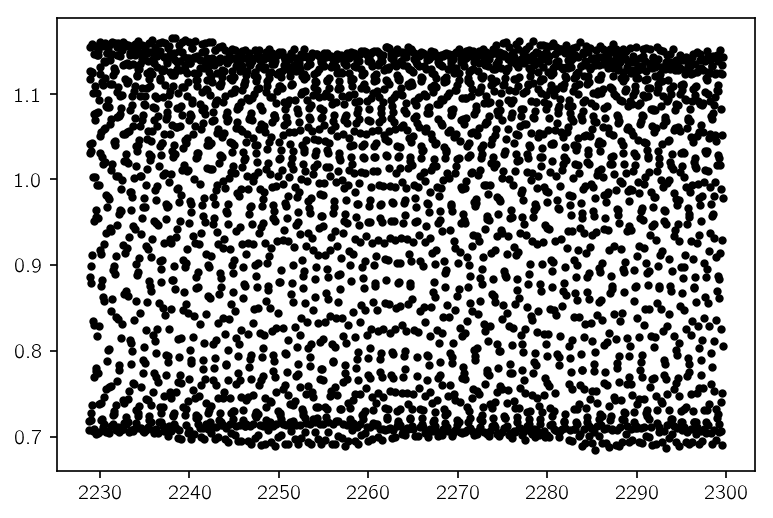

In [163]:
star = everest.Everest(210771656, quiet=True)
# star = everest.Everest(205625849, quiet=True)     # rrl; not awesome
# star = everest.Everest(205117205, quiet=True)     # rotation
# star = everest.Everest(211836369, quiet=True)     # quiet
t = star.apply_mask(star.time)
F = star.apply_mask(star.fpix)
# fdet = star.apply_mask(star.flux)

# Find the outliers
fsap = np.sum(F, axis = 1)
f = everest.math.SavGol(fsap)
M = np.nanmedian(f)
MAD = 1.4826 * np.nanmedian(np.abs(f - M))
out = (f > M + 5 * MAD) | (f < M - 5 * MAD)

# Apply the cut
t = np.array(t[~out])
fsap = np.array(fsap[~out])
F = np.array(F[~out,:])
# fdet = np.array(fdet[~out])

# Normalize
med = np.median(fsap)
fsap /= med
F /= med
# fdet /= med

# Plot
plt.plot(t, fsap, 'k.');

0.186755164813


/Users/dfm/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


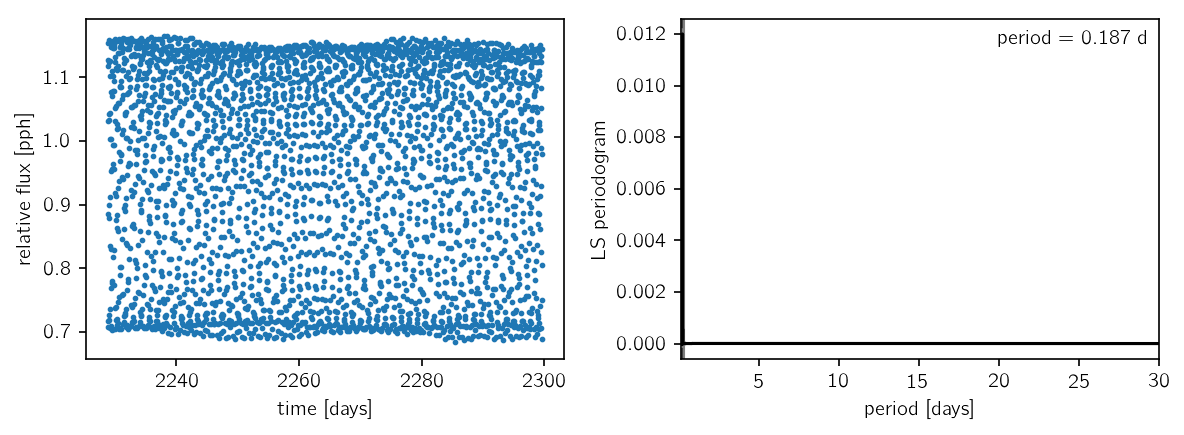

In [164]:
from astropy.stats import LombScargle

# First guess at the period
min_period, max_period = 0.1, 30.0

freq = np.linspace(1.0 / max_period, 1.0 / min_period, 5000)
model = LombScargle(t, fsap)
power = model.power(freq, method="fast", normalization="psd")
power /= len(t)
power0 = np.array(power)

# Filter
freq0 = 1.0 / 10.0
filt = 1.0 / np.sqrt(1 + (freq0 / freq) ** (2*3))
power *= filt

period = 1.0 / freq[np.argmax(power)]
print(period)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(t, fsap, s=3)
axes[0].set_ylabel("relative flux [pph]")
axes[0].set_xlabel("time [days]")

axes[1].plot(1.0 / freq, power, "k")
axes[1].axvline(period, color="k", alpha=0.5)
axes[1].axvline(0.5 * period, color="k", ls="dashed", alpha=0.5)
axes[1].set_xlabel("period [days]")
axes[1].set_ylabel("LS periodogram")
axes[1].annotate("period = {0:.3f} d".format(period), xy=(1, 1), xycoords="axes fraction",
                 ha="right", va="top", xytext=(-5, -5), textcoords="offset points")

axes[1].set_xlim(min_period, max_period)

fig.set_tight_layout(True)

In [165]:
from itertools import combinations_with_replacement as multichoose

A = F / fsap.reshape(-1, 1)
blocks = [A]

for order in range(2, 4):
    A2 = np.product(list(multichoose(A.T, order)), axis=1).T
    print(A2.shape)
    U, S, V = np.linalg.svd(A2 - np.mean(A2, axis=0), full_matrices=True)
    blocks.append(U[:, :order*A.shape[1]])

(3325, 496)
(3325, 5456)


In [166]:
tt = 2*(t - t.min()) / (t.max() - t.min()) - 1
blocks.append(np.vander(tt, 4))

In [167]:
A = np.concatenate(blocks, axis=1)
block_sizes = np.array([block.shape[1] for block in blocks])
block_inds = np.append(0, np.cumsum(block_sizes))
block_inds = list(zip(block_inds[:-1], block_inds[1:]))

In [168]:
block_inds

[(0, 31), (31, 93), (93, 186), (186, 190)]

In [169]:
import celerite
from celerite import terms

from rotate.rotation_term import RotationTerm, MixtureTerm, MixtureOfSHOsTerm

log_var = np.log(np.var(fsap))

kernel = terms.SHOTerm(
    log_S0=log_var,
    log_Q=-0.5*np.log(2), 
    log_omega0=np.log(2*np.pi/10.),
    bounds=dict(
        log_S0=(-20, 5),
        log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0)),
    ),
)
kernel.freeze_parameter('log_Q')

kernel += MixtureTerm(
    log_a1=log_var,
    log_b1=-0.1,
    log_f1=-5.0,
    log_P=np.log(period),
    mix_par=-1.0,
    log_b2=-0.1,
    log_f2=-5.0,
    bounds=dict(
        log_a1=(-20.0, 10.0),
        log_b1=(-20.0, 5.0),
        log_f1=(-20.0, 5.0),
        log_P=(np.log(min_period), np.log(max_period)),
        mix_par=(-5.0, 5.0),
        log_b2=(-20.0, 5.0),
        log_f2=(-20.0, 5.0),
    ),
)

yerr = np.nanmedian(np.abs(np.diff(fsap)))
kernel += terms.JitterTerm(log_sigma=np.log(yerr))

gp = celerite.GP(kernel=kernel, mean=1.)
gp.compute(t)
initial_gp_params = gp.get_parameter_vector()

In [170]:
from scipy.linalg import cho_factor, cho_solve

def get_weights(log_lams):
    alpha = np.dot(A.T, gp.apply_inverse(fsap - gp.mean.value)[:, 0])
    ATKinvA = np.dot(A.T, gp.apply_inverse(A))
    S = np.array(ATKinvA)
    dids = np.diag_indices_from(S)
    for bid, (s, f) in enumerate(block_inds):
        S[(dids[0][s:f], dids[1][s:f])] += np.exp(-log_lams[bid])
    factor = cho_factor(S, overwrite_a=True)
    alpha -= np.dot(ATKinvA, cho_solve(factor, alpha))
    for bid, (s, f) in enumerate(block_inds):
        alpha[s:f] *= np.exp(log_lams[bid])
    return alpha

def get_pred(log_lams):
    w = get_weights(log_lams)
    return np.dot(A, w)

def nll(params):
    log_lams = params[:len(block_inds)]
    gp.set_parameter_vector(params[len(block_inds):])

    r = fsap - gp.mean.value
    alpha = gp.apply_inverse(r)[:, 0]
    value = np.dot(r, alpha)
    ATalpha = np.dot(A.T, alpha)
    S = np.dot(A.T, gp.apply_inverse(A))
    dids = np.diag_indices_from(S)
    for bid, (s, f) in enumerate(block_inds):
        S[(dids[0][s:f], dids[1][s:f])] += np.exp(-log_lams[bid])
    factor = cho_factor(S, overwrite_a=True)
    value -= np.dot(ATalpha, cho_solve(factor, ATalpha))
   
    # Penalty terms
    log_det = 2*np.sum(np.log(np.diag(factor[0])))
    log_det += np.sum(log_lams * block_sizes)
    log_det += gp.solver.log_determinant()
   
    return 0.5 * (value + log_det)

In [171]:
from scipy.optimize import minimize

initial = np.log(1) * np.ones(len(block_inds))
initial[-1] = np.log(20)
initial = np.append(initial, initial_gp_params)
bounds = [(-20, 10) for _ in block_inds] + gp.get_parameter_bounds()
soln = minimize(nll, initial, bounds=bounds)
soln

      fun: -13827.575670228756
 hess_inv: <14x14 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.71419446e+00,  -5.69343683e-01,  -8.71295924e-02,
         1.95977918e+00,  -3.72892828e-02,   9.45874490e-03,
        -6.28460839e-01,   1.26728992e+00,   2.06455297e-01,
         2.55326459e+04,   3.82533472e-01,  -6.55381882e-01,
         6.73026079e-03,   1.43068974e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2340
      nit: 109
   status: 0
  success: True
        x: array([ -0.09335032,  -8.33079357, -14.89039979,   2.10184914,
        -8.87261833,  -2.54414947,  -0.74054077,   3.87749769,
       -16.74066674,  -1.67789609,  -0.66332771,   4.3262253 ,
       -19.99999999,  -4.69204289])

In [172]:
initial

array([ 0.        ,  0.        ,  0.        ,  2.99573227, -3.69559964,
       -0.46470803, -3.69559964, -0.1       , -5.        , -1.6779568 ,
       -1.        , -0.1       , -5.        , -2.34969817])

In [173]:
log_lams = soln.x[:len(block_inds)]
gp.set_parameter_vector(soln.x[len(block_inds):])
print(log_lams)

[ -0.09335032  -8.33079357 -14.89039979   2.10184914]


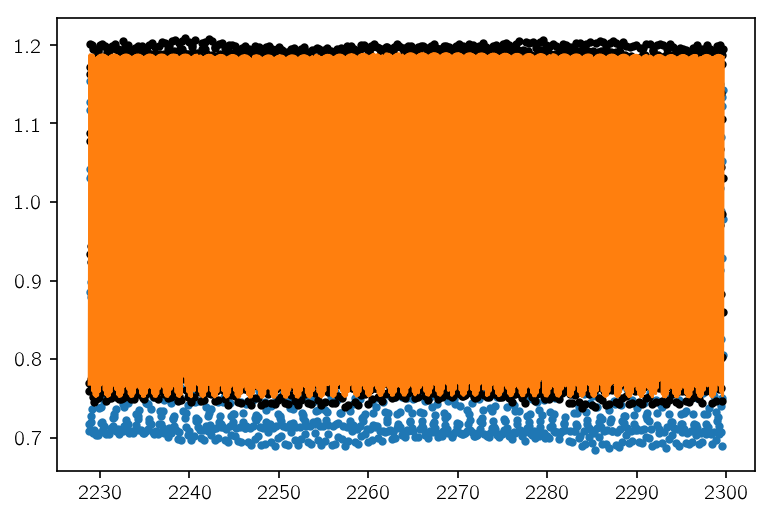

In [174]:
mu = get_pred(log_lams)
fdet = fsap - mu
gppred = gp.predict(fdet, return_cov=False)
plt.plot(t, fsap, '.');
plt.plot(t, fdet, 'k.');
plt.plot(t, gppred)

In [175]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -8.8726183326130954),
             ('kernel:terms[0]:log_omega0', -2.544149472575854),
             ('kernel:terms[1]:log_a1', -0.74054076960539506),
             ('kernel:terms[1]:log_b1', 3.877497690537044),
             ('kernel:terms[1]:log_f1', -16.740666743606631),
             ('kernel:terms[1]:log_P', -1.6778960924114428),
             ('kernel:terms[1]:mix_par', -0.66332770510160999),
             ('kernel:terms[1]:log_b2', 4.326225304630273),
             ('kernel:terms[1]:log_f2', -19.999999991491951),
             ('kernel:terms[2]:log_sigma', -4.6920428902229476)])

In [176]:
period = np.exp(gp.get_parameter("kernel:terms[1]:log_P"))
print(period)

0.186766502437


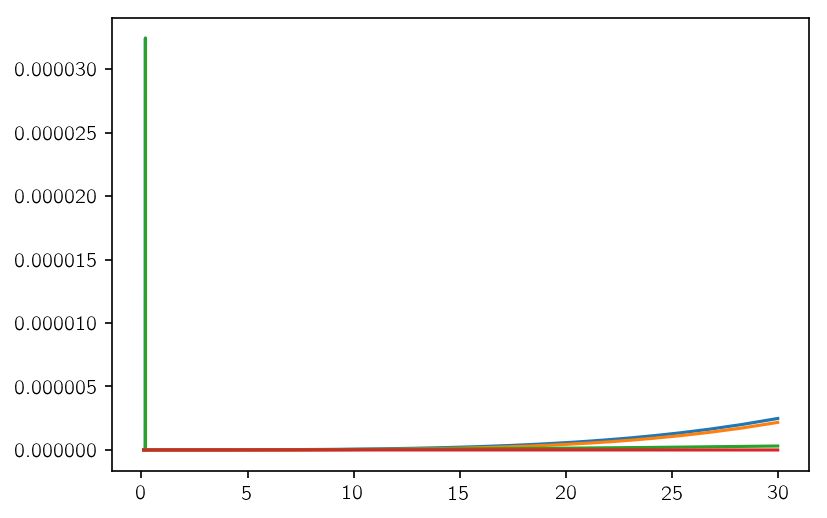

In [177]:
omega = 2 * np.pi * freq
plt.plot(1./freq, gp.kernel.get_psd(omega))
for term in gp.kernel.terms:
    plt.plot(1./freq, term.get_psd(omega))

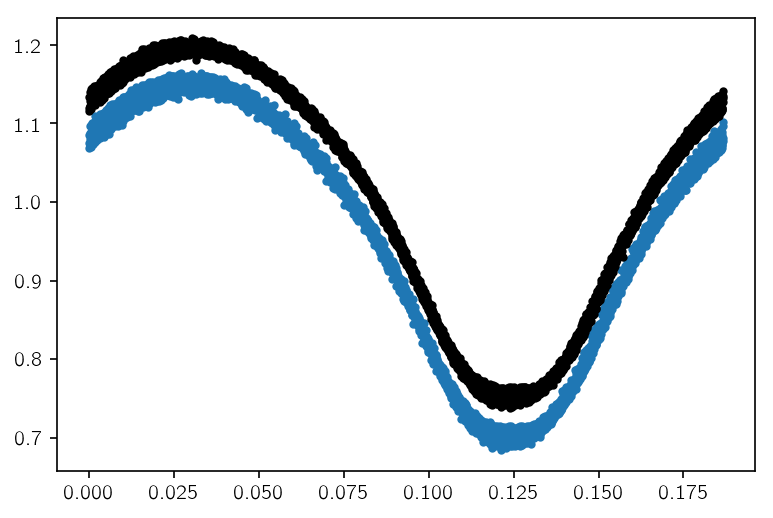

In [178]:
plt.plot(t % period, fsap, '.');
plt.plot(t % period, fdet, 'k.');

In [ ]:
gp.set_parameter("kernel:terms[1]:log_P")

params = np.append(log_lams, gp.get_parameter_vector())